## Inference Image Test notebook ##


In [1]:
import sys, os
sys.path.append("./models/")
sys.path.append("./datasets/")
sys.path.append("./utils/")

In [2]:
import beautydataset
import beautynet
import image_preprocess
import beautynet_inference

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from skimage import io
import face_alignment
import torchvision
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
import torchvision.transforms as transforms
import torchvision.datasets.folder as folder
from PIL import Image
from tqdm import tqdm

## cuda 사용 필수 ##

In [4]:
net = beautynet.BeautyNet(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=60).cuda()

In [5]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, enable_cuda=True)

In [6]:
# save_state = "./checkpoints/beautynet_04121419_no_person"
save_state = "./checkpoints/beautynet_04130954_no_person"
net = beautynet_inference.load_model(net, save_state)

In [7]:
def show_img_and_landmarks(img):
    """
    numpy image array -> landmark + image
    return landmark (68 x 2)
    """
    fig = plt.figure()
    ax = fig.add_subplot(121)
    ax.imshow(img)
    ax = fig.add_subplot(122)
    ax.imshow(img)
    markersize = 1
    preds = fa.get_landmarks(img)[0]
    # 턱선
    ax.plot(preds[0:17,0],preds[0:17,1],marker='o',markersize=markersize,linestyle='-',color='w',lw=2)
    # 오른눈썹
    ax.plot(preds[17:22,0],preds[17:22,1],marker='o',markersize=markersize,linestyle='-',color='w',lw=2)
    # 왼눈썹
    ax.plot(preds[22:27,0],preds[22:27,1],marker='o',markersize=markersize,linestyle='-',color='w',lw=2)
    # 콧대
    ax.plot(preds[27:31,0],preds[27:31,1],marker='o',markersize=markersize,linestyle='-',color='w',lw=2)
    # 콧구멍라인
    ax.plot(preds[31:36,0],preds[31:36,1],marker='o',markersize=markersize,linestyle='-',color='w',lw=2)
    # 오른눈
    ax.plot(preds[36:42,0],preds[36:42,1],marker='o',markersize=markersize,linestyle='-',color='w',lw=1)
    # 왼눈
    ax.plot(preds[42:48,0],preds[42:48,1],marker='o',markersize=markersize,linestyle='-',color='w',lw=2)
    # 입술 밖
    ax.plot(preds[48:60,0],preds[48:60,1],marker='o',markersize=markersize,linestyle='-',color='w',lw=2)
    # 입술 안
    ax.plot(preds[60:68,0],preds[60:68,1],marker='o',markersize=markersize,linestyle='-',color='w',lw=2)
    ax.axis('off')
    return preds

## 학습 데이터에 대한 결과 확인 ##
- 여기서 결과가 이상하면 모델 학습이 이상한 것

In [ ]:
image_list = glob.glob(os.path.join('./datasets/ImageFolder/', "fty*.jpg"))
true_data = pd.read_csv("./datasets/median.csv")

In [ ]:
net.eval()
pred_list = []
for i, path in (enumerate(sorted(image_list))):
    score = beautynet_inference.inference_image(fa, net, path)
    pred_list.append(score)
    true_score =  true_data.loc[true_data['Filename'] == path, "Rating"].values
    print(f"expected score{score}, true_score{true_score}")
    if i % 10 == 2:
        break

In [22]:
image_path = "./datasets/celebs/celeb7.jpg"
image_path = ["./datasets/celebs/celeb7.jpg", "./datasets/celebs/celeb6.jpg"]
# image_path = "./datasets/ImageFolder/mty1.jpg"

In [9]:
score = beautynet_inference.inference_image(fa, net, image_path)
score

/home/jongho/anaconda3/envs/pt4/lib/python3.6/site-packages/face_alignment-0.1.0-py3.6.egg/face_alignment/api.py:185: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  Variable(inp, volatile=True))[-1].data.cpu()


2.260324478149414

/home/jongho/anaconda3/envs/pt4/lib/python3.6/site-packages/face_alignment-0.1.0-py3.6.egg/face_alignment/api.py:185: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  Variable(inp, volatile=True))[-1].data.cpu()


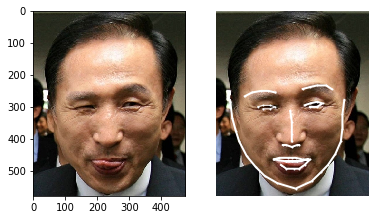

In [10]:
_ = show_img_and_landmarks(io.imread(image_path))

In [19]:
import imp
beautynet_inference = imp.reload(beautynet_inference)

In [23]:
bottleneck = beautynet_inference.get_bottleneck_of_image(fa, net, image_path)

/home/jongho/anaconda3/envs/pt4/lib/python3.6/site-packages/face_alignment-0.1.0-py3.6.egg/face_alignment/api.py:185: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  Variable(inp, volatile=True))[-1].data.cpu()


(3, 350, 350)
0
1
2
(3, 350, 350)
0
1
2


In [24]:
bottleneck



Columns 0 to 7 
-103.0770   89.0724  -76.9677  177.6750  -57.9108   21.7203  -15.7297  -97.4106
 -98.6985   83.8229  -74.4225  170.7486  -56.8712   20.0998  -10.4330  -89.4550

Columns 8 to 15 
 -47.3985 -101.0127  -88.0444  -17.4380 -199.5269 -102.9817   17.4699  -14.0134
 -41.2968  -92.5945  -80.9677  -17.3309 -189.3904  -96.5541   17.7742  -11.1237

Columns 16 to 23 
-199.4727    3.9683  -46.8725 -175.6649   34.1288  -55.8211  -47.0824 -123.3692
-189.2417    4.9130  -44.1105 -162.0028   28.6938  -52.0541  -47.9852 -117.1673

Columns 24 to 31 
 280.3940  -37.9829  -91.8731 -120.6165   49.3260   -6.2292    0.8324  -70.8128
 262.6607  -31.0376  -90.2796 -115.5504   53.0949   -5.0274   -2.4229  -66.6047

Columns 32 to 39 
 -86.0561  201.0391 -107.9359 -131.7781 -215.5832   83.7892   26.4255  -40.9834
 -81.6095  191.9144  -99.6211 -125.0983 -202.8275   80.6149   24.7978  -37.1932

Columns 40 to 47 
-129.3525  108.0554 -121.7404  -65.0381  -38.4807  -20.8323 -145.3762  -76.8180
-119.758